# Car Fuel Efficiency Regression

### The goal of this homework is to create a regression model for predicting the car fuel efficiency (column 'fuel_efficiency_mpg').

## Setup and Data Loading

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error

# Load dataset
file_path = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv'
df = pd.read_csv(file_path)

# Keep only the required columns
cols = ['engine_displacement','horsepower','vehicle_weight','model_year','fuel_efficiency_mpg']
df = df[cols].copy()

df.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


## EDA

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
count,9704.000000,8996.000000,9704.000000,9704.000000,9704.000000
mean,199.708368,149.657292,3001.280993,2011.484027,14.985243
std,49.455319,29.879555,497.894860,6.659808,2.556468
min,10.000000,37.000000,952.681761,2000.000000,6.200971
25%,170.000000,130.000000,2666.248985,2006.000000,13.267459
50%,200.000000,149.000000,2993.226296,2012.000000,15.006037
75%,230.000000,170.000000,3334.957039,2017.000000,16.707965
max,380.000000,271.000000,4739.077089,2023.000000,25.967222



Missing per column:
engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64
Skew of fuel_efficiency_mpg: -0.012


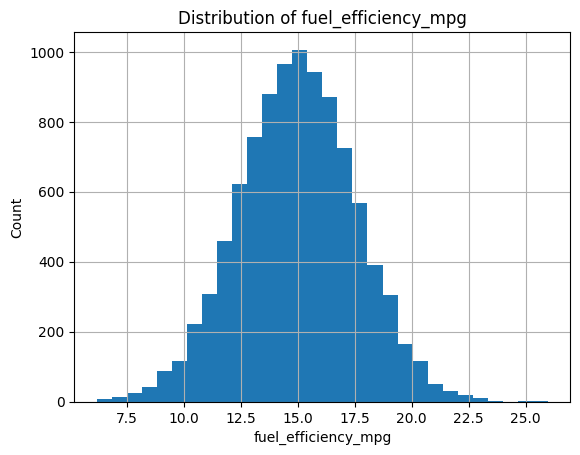

Has long tail? False


In [3]:
# Basic info
display(df.describe(include='all'))
print("\nMissing per column:")
print(df.isna().sum())

# Look at the distribution of target
target = 'fuel_efficiency_mpg'
skew = df[target].skew()
print(f"Skew of {target}: {skew:.3f}")

plt.figure()
df[target].hist(bins=30)
plt.title('Distribution of fuel_efficiency_mpg')
plt.xlabel('fuel_efficiency_mpg')
plt.ylabel('Count')
plt.show()

# Heuristic for long tail: absolute skew > 1 often indicates a long tail
has_long_tail = abs(skew) > 1
print("Has long tail?", has_long_tail)


In [22]:
na_counts = df.isna().sum()
na_counts

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

## Questions 1 & 2
* Look at the `fuel_efficiency_mpg` variable. Does it have a long tail? 
* What's the median (50% percentile) for variable `'horsepower'`?

In [29]:
# Q1: which single column has missing values?
na_counts = df.isna().sum().sort_values(ascending=False)
q1_column = na_counts.index[0] if na_counts.iloc[0] > 0 else None
print("Q1 - Column with missing values:", q1_column)

# Q2: median horsepower (50th percentile)
hp_median = df['horsepower'].median()
print("Q2 - Median horsepower:", hp_median)


Q1 - Column with missing values: horsepower
Q2 - Median horsepower: 149.0


## Utilities: Split and RMSE

In [7]:
def prepare_splits(dataframe, seed=42):
    # Shuffle first (reproducible)
    df_shuffled = dataframe.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    # 60/20/20 split: first split train vs tmp, then tmp into val/test
    df_train, df_tmp = train_test_split(df_shuffled, test_size=0.4, random_state=seed)
    df_val, df_test = train_test_split(df_tmp, test_size=0.5, random_state=seed)
    return df_train.reset_index(drop=True), df_val.reset_index(drop=True), df_test.reset_index(drop=True)

def rmse(y_true, y_pred):
    import numpy as np
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

feature_cols = ['engine_displacement','horsepower','vehicle_weight','model_year']
target_col = 'fuel_efficiency_mpg'

## Question 3 — Missing value strategies (0 vs mean)
* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?

In [8]:
# Use seed 42 and create splits
df_train, df_val, df_test = prepare_splits(df, seed=42)

# Option A: fill missing with 0
X_train_A = df_train[feature_cols].fillna(0).values
y_train = df_train[target_col].values
X_val_A = df_val[feature_cols].fillna(0).values
y_val = df_val[target_col].values

lr_A = LinearRegression()
lr_A.fit(X_train_A, y_train)
preds_A = lr_A.predict(X_val_A)
rmse_A = rmse(y_val, preds_A)

# Option B: fill missing with train-mean
train_means = df_train[feature_cols].mean()
X_train_B = df_train[feature_cols].fillna(train_means).values
X_val_B = df_val[feature_cols].fillna(train_means).values

lr_B = LinearRegression()
lr_B.fit(X_train_B, y_train)
preds_B = lr_B.predict(X_val_B)
rmse_B = rmse(y_val, preds_B)

print("Q3 - RMSE with 0     :", round(rmse_A, 2))
print("Q3 - RMSE with mean :", round(rmse_B, 2))
better_q3 = "With mean" if round(rmse_B, 2) < round(rmse_A, 2) else ("With 0" if round(rmse_A, 2) < round(rmse_B, 2) else "Both are equally good")
print("Q3 - Better option  :", better_q3)


Q3 - RMSE with 0     : 0.51
Q3 - RMSE with mean : 0.46
Q3 - Better option  : With mean


## Question 4 — Ridge regression hyperparameter r
* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0. 
* Try different values of `r` from this list: `[0, 0.01, 0.1, 1, 5, 10, 100]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

In [15]:
r_values = [0, 0.01, 0.1, 1, 5, 10, 100]

# Use the same split (seed 42)
df_train, df_val, df_test = prepare_splits(df, seed=42)

X_train = df_train[feature_cols].fillna(0).values
y_train = df_train[target_col].values
X_val = df_val[feature_cols].fillna(0).values
y_val = df_val[target_col].values

scores = []
for r in r_values:
    if r == 0:
        model = LinearRegression()
    else:
        model = Ridge(alpha=r, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    score = rmse(y_val, preds)
    scores.append((float(r), float(round(score, 2))))
    scores_clean = [(float(r), float(v)) for r, v in scores]

scores_sorted = sorted(scores, key=lambda x: (x[1], x[0]))  # sort by RMSE then by smallest r
best_r, best_rmse = scores_sorted[0]
print("Q4 - RMSE by r:", scores)
print(f"Q4 - Best r: {best_r} with RMSE {best_rmse}")

Q4 - RMSE by r: [(0.0, 0.51), (0.01, 0.51), (0.1, 0.51), (1.0, 0.51), (5.0, 0.51), (10.0, 0.51), (100.0, 0.51)]
Q4 - Best r: 0.0 with RMSE 0.51


## Question 5 — Variability across seeds
* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)

In [16]:
seed_list = list(range(10))
val_rmses = []

for s in seed_list:
    df_train, df_val, df_test = prepare_splits(df, seed=s)
    X_train = df_train[feature_cols].fillna(0).values
    y_train = df_train[target_col].values
    X_val = df_val[feature_cols].fillna(0).values
    y_val = df_val[target_col].values

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    preds = lr.predict(X_val)
    val_rmses.append(rmse(y_val, preds))

std_val = float(np.std(val_rmses))
print("Q5 - Validation RMSEs:", [round(v, 3) for v in val_rmses])
print("Q5 - Std of RMSEs   :", round(std_val, 3))

Q5 - Validation RMSEs: [np.float64(0.518), np.float64(0.509), np.float64(0.514), np.float64(0.515), np.float64(0.518), np.float64(0.524), np.float64(0.515), np.float64(0.525), np.float64(0.508), np.float64(0.529)]
Q5 - Std of RMSEs   : 0.007


## Question 6 — Train on train+val (seed 9), Ridge r=0.001, NA=0, Test RMSE
* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`. 
* What's the RMSE on the test dataset?

In [17]:
# Split with seed 9
df_train, df_val, df_test = prepare_splits(df, seed=9)

# Combine train + val
df_tr_full = pd.concat([df_train, df_val], ignore_index=True)

X_tr = df_tr_full[feature_cols].fillna(0).values
y_tr = df_tr_full[target_col].values
X_te = df_test[feature_cols].fillna(0).values
y_te = df_test[target_col].values

ridge = Ridge(alpha=0.001, random_state=42)
ridge.fit(X_tr, y_tr)
preds_te = ridge.predict(X_te)
rmse_test = rmse(y_te, preds_te)
print("Q6 - Test RMSE:", round(rmse_test, 3))


Q6 - Test RMSE: 0.532


## Conclusion

In [19]:
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split

def prepare_splits(dataframe, seed=42):
    df_shuffled = dataframe.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    df_train, df_tmp = train_test_split(df_shuffled, test_size=0.4, random_state=seed)
    df_val, df_test = train_test_split(df_tmp, test_size=0.5, random_state=seed)
    return df_train.reset_index(drop=True), df_val.reset_index(drop=True), df_test.reset_index(drop=True)

feature_cols = ['engine_displacement','horsepower','vehicle_weight','model_year']
target_col = 'fuel_efficiency_mpg'

# Q1 & Q2 (already computed above, just recompute quickly for certainty)
na_counts = df.isna().sum().sort_values(ascending=False)
q1_column = na_counts.index[0] if na_counts.iloc[0] > 0 else None
hp_median = df['horsepower'].median()

# Q3
df_train, df_val, df_test = prepare_splits(df, seed=42)

X_train_A = df_train[feature_cols].fillna(0).values
y_train = df_train[target_col].values
X_val_A = df_val[feature_cols].fillna(0).values
y_val = df_val[target_col].values
lr_A = LinearRegression().fit(X_train_A, y_train)
rmse_A = rmse(y_val, lr_A.predict(X_val_A))

train_means = df_train[feature_cols].mean()
X_train_B = df_train[feature_cols].fillna(train_means).values
X_val_B = df_val[feature_cols].fillna(train_means).values
lr_B = LinearRegression().fit(X_train_B, y_train)
rmse_B = rmse(y_val, lr_B.predict(X_val_B))

q3_choice = "With mean" if round(rmse_B, 2) < round(rmse_A, 2) else ("With 0" if round(rmse_A, 2) < round(rmse_B, 2) else "Both are equally good")

# Q4
r_values = [0, 0.01, 0.1, 1, 5, 10, 100]
X_train = df_train[feature_cols].fillna(0).values
y_train = df_train[target_col].values
X_val = df_val[feature_cols].fillna(0).values
y_val = df_val[target_col].values
scores = []
for r in r_values:
    model = LinearRegression() if r == 0 else Ridge(alpha=r, random_state=42)
    model.fit(X_train, y_train)
    score = rmse(y_val, model.predict(X_val))
    scores.append((r, round(score, 2)))
best_r, best_rmse = sorted(scores, key=lambda x: (x[1], x[0]))[0]

# Q5
seed_list = list(range(10))
val_rmses = []
for s in seed_list:
    dtr, dval, dte = prepare_splits(df, seed=s)
    X_tr = dtr[feature_cols].fillna(0).values
    y_tr = dtr[target_col].values
    X_v = dval[feature_cols].fillna(0).values
    y_v = dval[target_col].values
    lr = LinearRegression().fit(X_tr, y_tr)
    val_rmses.append(rmse(y_v, lr.predict(X_v)))
std_val = round(float(np.std(val_rmses)), 3)

# Q6
dtr, dval, dte = prepare_splits(df, seed=9)
df_tr_full = pd.concat([dtr, dval], ignore_index=True)
X_tr = df_tr_full[feature_cols].fillna(0).values
y_tr = df_tr_full[target_col].values
X_te = dte[feature_cols].fillna(0).values
y_te = dte[target_col].values
ridge = Ridge(alpha=0.001, random_state=42).fit(X_tr, y_tr)
rmse_test = round(rmse(y_te, ridge.predict(X_te)), 3)

print("EDA: Long tail in fuel_efficiency_mpg? ->", abs(df[target_col].skew()) > 1)
print("Q1 (missing column)      ->", q1_column)
print("Q2 (median horsepower)   ->", int(hp_median) if float(hp_median).is_integer() else float(hp_median))
print("Q3 (better imputation)   ->", q3_choice, "| RMSE(0) =", round(rmse_A,2), ", RMSE(mean) =", round(rmse_B,2))
print("Q4 (best r)              ->", best_r, "| RMSE =", best_rmse, "| All:", scores)
print("Q5 (std of RMSEs)        ->", std_val)
print("Q6 (test RMSE, r=0.001)  ->", rmse_test)


EDA: Long tail in fuel_efficiency_mpg? -> False
Q1 (missing column)      -> horsepower
Q2 (median horsepower)   -> 149
Q3 (better imputation)   -> With mean | RMSE(0) = 0.51 , RMSE(mean) = 0.46
Q4 (best r)              -> 0 | RMSE = 0.51 | All: [(0, np.float64(0.51)), (0.01, np.float64(0.51)), (0.1, np.float64(0.51)), (1, np.float64(0.51)), (5, np.float64(0.51)), (10, np.float64(0.51)), (100, np.float64(0.51))]
Q5 (std of RMSEs)        -> 0.007
Q6 (test RMSE, r=0.001)  -> 0.532
